<a href="https://colab.research.google.com/github/Anjalee-29/Object-Tracking-in-Surveillance-Videos/blob/main/hmd_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install transformers
!pip install tensorflow
!pip install matplotlib
!pip install wordcloud
!pip install nltk
!pip install scikit-learn
!pip install keras

In [ ]:
# Upload Kaggle API credentials file
from google.colab import files
files.upload()  # Upload kaggle.json

# Set up Kaggle API
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

# Install Kaggle API and use it to download the dataset
!pip install kaggle

# Download the dataset from Kaggle
!kaggle datasets download parthplc/facebook-hateful-meme-dataset

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/parthplc/facebook-hateful-meme-dataset
License(s): unknown
100% 3.35G/3.35G [00:51<00:00, 106MB/s] 
100% 3.35G/3.35G [00:51<00:00, 69.8MB/s]


In [ ]:
# Unzip the dataset
import zipfile
dataset_path = '/content/facebook-hateful-meme-dataset.zip'
unzip_dir = '/content/hateful-memes/'

# Check if the file exists and unzip
if os.path.exists(dataset_path):
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall(unzip_dir)
    print(f"Dataset extracted to {unzip_dir}")
else:
    print(f"File {dataset_path} not found!")

Dataset extracted to /content/hateful-memes/


In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from transformers import BertTokenizer
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [ ]:
import os
os.listdir('/content')  # or a specific directory like '/content/your-folder/'

['.config',
 'facebook-hateful-meme-dataset.zip',
 'hateful-memes',
 'kaggle.json',
 'sample_data']

In [ ]:
os.remove('/content/facebook-hateful-meme-dataset.zip')  # delete unuseful data

In [ ]:
os.listdir('/content/hateful-memes')

['data']

In [ ]:
os.listdir('/content/hateful-memes/data')

['test.jsonl', 'img', 'dev.jsonl', 'README.md', 'LICENSE.txt', 'train.jsonl']

In [ ]:
# Load the file containing meme data
df_train = pd.read_json('/content/hateful-memes/data/train.jsonl', lines=True)

# Check the structure of the dataframe
df_train.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [ ]:
# Construct full image paths (assuming images are stored in the 'img/' folder)
image_paths = df_train['img'].apply(lambda x: '/content/hateful-memes/Data/' + x)
texts = df_train['text']
labels = df_train['label']

# Check the first few entries
print(image_paths.head())
print(texts.head())
print(labels.head())

0    /content/hateful-memes/Data/img/42953.png
1    /content/hateful-memes/Data/img/23058.png
2    /content/hateful-memes/Data/img/13894.png
3    /content/hateful-memes/Data/img/37408.png
4    /content/hateful-memes/Data/img/82403.png
Name: img, dtype: object
0     its their character not their color that matters
1    don't be afraid to love again everyone is not ...
2                             putting bows on your pet
3    i love everything and everybody! except for sq...
4    everybody loves chocolate chip cookies, even h...
Name: text, dtype: object
0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64


In [ ]:
df_test = pd.read_json('/content/hateful-memes/data/test.jsonl', lines=True)

# Check the structure of the dataframe
df_test.head()

,id,img,text
0,16395,img/16395.png,handjobs sold seperately
1,37405,img/37405.png,introducing fidget spinner for women
2,94180,img/94180.png,happy pride month let's go beat up lesbians
3,54321,img/54321.png,laughs in [majority of u.s crime rate]
4,97015,img/97015.png,finds out those 72 virgins.. are goats


In [ ]:
# Extract image paths and text for the test data
image_paths_test = df_test['img'].apply(lambda x: '/content/hateful-memes/Data/' + x)
texts_test = df_test['text']

# Check the first few entries
print(image_paths_test.head())
print(texts_test.head())

0    /content/hateful-memes/Data/img/16395.png
1    /content/hateful-memes/Data/img/37405.png
2    /content/hateful-memes/Data/img/94180.png
3    /content/hateful-memes/Data/img/54321.png
4    /content/hateful-memes/Data/img/97015.png
Name: img, dtype: object
0                       handjobs sold seperately
1           introducing fidget spinner for women
2    happy pride month let's go beat up lesbians
3         laughs in [majority of u.s crime rate]
4         finds out those 72 virgins.. are goats
Name: text, dtype: object


In [ ]:
df_dev = pd.read_json('/content/hateful-memes/data/dev.jsonl', lines=True)

# Check the structure of the dataframe
df_dev.head()

,id,img,label,text
0,8291,img/08291.png,1,white people is this a shooting range
1,46971,img/46971.png,1,bravery at its finest
2,3745,img/03745.png,1,your order comes to $37.50 and your white priv...
3,83745,img/83745.png,1,it is time.. to send these parasites back to t...
4,80243,img/80243.png,1,mississippi wind chime


In [ ]:
import pandas as pd
from transformers import BertTokenizer
import numpy as np

# Load the dataset
df = pd.read_json('/content/hateful-memes/data/train.jsonl', lines=True)

# Check the structure of the dataframe
print(df.columns)  # Inspect the column names to ensure you have 'text'

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and pad the text data
def tokenize_text(texts, max_length=128):
    encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=max_length)
    return np.array(encodings['input_ids'])

# Tokenize the text column
texts = tokenize_text(df['text'])

# Check the shape of the tokenized text data
print(f'Tokenized text shape: {texts.shape}')

Index(['id', 'img', 'label', 'text'], dtype='object')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenized text shape: (8500, 88)


In [ ]:
import pandas as pd
from transformers import BertTokenizer
import numpy as np

# Load the dataset
df = pd.read_json('/content/hateful-memes/data/train.jsonl', lines=True)

# Check the structure of the dataframe
print(df.columns)  # Inspect the column names to ensure you have 'text'

# Check for missing values in the 'text' column and handle them
df['text'] = df['text'].fillna('')  # Replace NaNs with empty string (you can also choose to drop rows)

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and pad the text data
def tokenize_text(texts, max_length=128):
    encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='np')
    return encodings['input_ids'], encodings['attention_mask']

# Tokenize the text column
input_ids, attention_masks = tokenize_text(df['text'])

# Check the shape of the tokenized text data
print(f'Tokenized input_ids shape: {input_ids.shape}')
print(f'Tokenized attention_mask shape: {attention_masks.shape}')

Index(['id', 'img', 'label', 'text'], dtype='object')
Tokenized input_ids shape: (8500, 88)
Tokenized attention_mask shape: (8500, 88)


In [ ]:
os.listdir('/content/hateful-memes/data/img')

['58417.png',
 '92837.png',
 '97283.png',
 '38609.png',
 '19678.png',
 '76851.png',
 '73810.png',
 '30597.png',
 '71058.png',
 '35087.png',
 '47605.png',
 '96328.png',
 '30256.png',
 '31429.png',
 '71263.png',
 '70582.png',
 '81536.png',
 '84927.png',
 '12468.png',
 '24039.png',
 '08593.png',
 '05916.png',
 '86504.png',
 '39725.png',
 '23048.png',
 '73659.png',
 '42319.png',
 '75234.png',
 '19542.png',
 '17956.png',
 '92086.png',
 '73568.png',
 '50286.png',
 '26381.png',
 '68917.png',
 '85409.png',
 '27034.png',
 '30782.png',
 '75402.png',
 '81256.png',
 '37865.png',
 '59073.png',
 '34852.png',
 '04769.png',
 '27861.png',
 '01793.png',
 '02958.png',
 '90826.png',
 '67841.png',
 '36158.png',
 '60732.png',
 '56819.png',
 '70539.png',
 '82794.png',
 '69134.png',
 '80672.png',
 '42168.png',
 '68745.png',
 '07912.png',
 '71539.png',
 '57421.png',
 '78925.png',
 '19763.png',
 '46910.png',
 '92354.png',
 '02146.png',
 '35276.png',
 '56830.png',
 '90583.png',
 '17504.png',
 '53096.png',
 '5180

In [ ]:
import os

# List all image files in the 'img' folder
img_files = os.listdir('/content/hateful-memes/data/img')
print(img_files)

['58417.png', '92837.png', '97283.png', '38609.png', '19678.png', '76851.png', '73810.png', '30597.png', '71058.png', '35087.png', '47605.png', '96328.png', '30256.png', '31429.png', '71263.png', '70582.png', '81536.png', '84927.png', '12468.png', '24039.png', '08593.png', '05916.png', '86504.png', '39725.png', '23048.png', '73659.png', '42319.png', '75234.png', '19542.png', '17956.png', '92086.png', '73568.png', '50286.png', '26381.png', '68917.png', '85409.png', '27034.png', '30782.png', '75402.png', '81256.png', '37865.png', '59073.png', '34852.png', '04769.png', '27861.png', '01793.png', '02958.png', '90826.png', '67841.png', '36158.png', '60732.png', '56819.png', '70539.png', '82794.png', '69134.png', '80672.png', '42168.png', '68745.png', '07912.png', '71539.png', '57421.png', '78925.png', '19763.png', '46910.png', '92354.png', '02146.png', '35276.png', '56830.png', '90583.png', '17504.png', '53096.png', '51804.png', '81976.png', '62149.png', '36814.png', '64130.png', '61497.png'

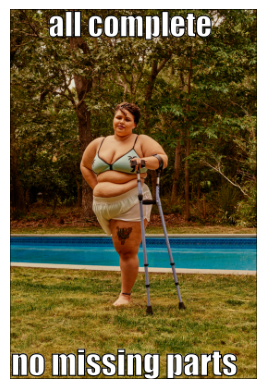

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the first image from the list
img_path = '/content/hateful-memes/data/img/' + img_files[0]  # Path to the first image
img = Image.open(img_path)

# Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

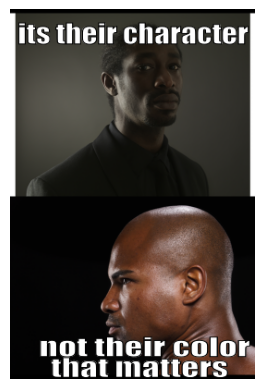

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Get the list of image files (from the 'img' column)
img_files = df['img'].tolist()

# Load the first image from the list
img_path = '/content/hateful-memes/data/' + img_files[0]  # Path to the first image
img = Image.open(img_path)

# Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

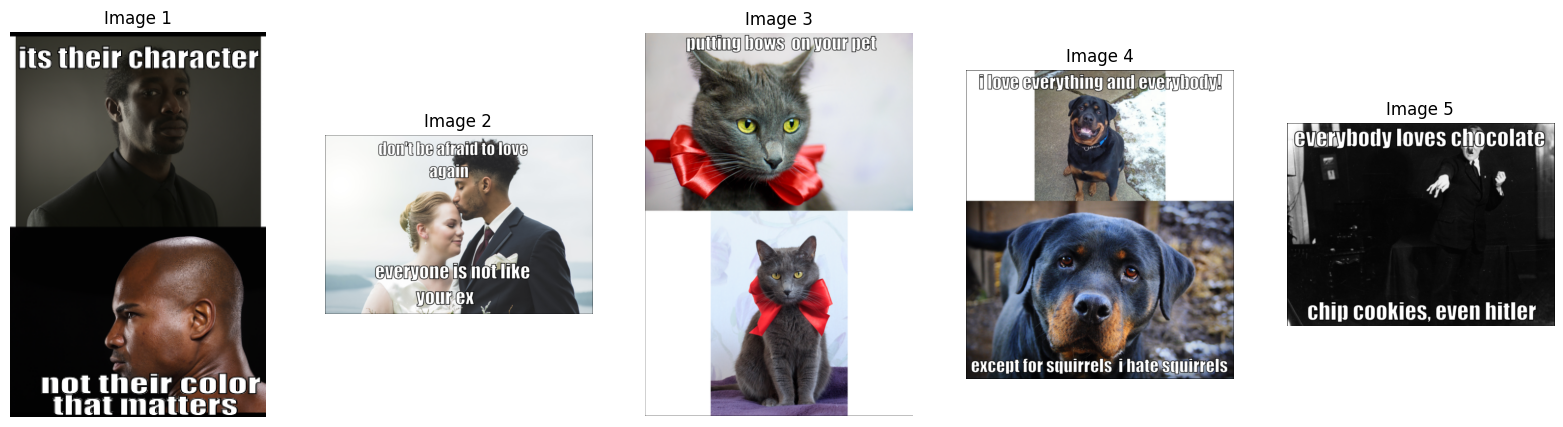

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Extract the list of image files from the 'img' column in the DataFrame
img_files = df['img'].tolist()

# Display the first 5 images in the img folder
fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # Create a grid of 5 subplots
for i in range(5):
    img_path = '/content/hateful-memes/data/' + img_files[i]  # Get the image path
    img = Image.open(img_path)  # Open the image using PIL
    axes[i].imshow(img)  # Display the image on the respective axis
    axes[i].axis('off')  # Hide axes for clean display
    axes[i].set_title(f'Image {i+1}')  # Title for each image

plt.show()  # Show all images at once

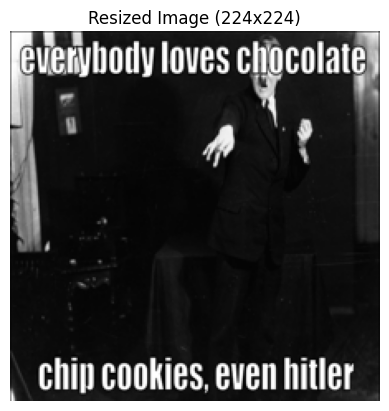

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Resize the first image to 224x224
img_resized = img.resize((224, 224))

# Display the resized image using matplotlib
plt.imshow(img_resized)
plt.axis('off')  # Hide axes
plt.title('Resized Image (224x224)')
plt.show()

In [ ]:
import numpy as np
from PIL import Image

# Resize all images to 224x224 and store them in a NumPy array
images = []
for img_file in img_files[:5]:  # Load the first 5 images (adjust as needed)
    # Fix: Correctly construct the image path without double 'img/' prefixes
    img_path = '/content/hateful-memes/data/' + img_file  # Only append img_file directly
    img = Image.open(img_path)

    # Resize the image to 224x224
    img_resized = img.resize((224, 224))

    # Convert to a NumPy array and append to the images list
    images.append(np.array(img_resized))

# Convert the list of images to a NumPy array
X_train_images = np.array(images)

# Check the shape of the resulting NumPy array
print(X_train_images.shape)  # Should print (5, 224, 224, 3) for 5 images

(5, 224, 224, 3)


In [ ]:
# Check the columns in the DataFrame
print(df.columns)

Index(['id', 'img', 'label', 'text'], dtype='object')


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load and preprocess images
def load_image(img_file, img_dir='/content/hateful-memes/data'):
    # Use img_file directly (no need to add 'img/' again)
    img_path = os.path.join(img_dir, img_file)  # Correctly join the directory and image file
    img = load_img(img_path, target_size=(224, 224))  # Resize image to (224, 224)
    img = img_to_array(img) / 255.0  # Normalize the image to [0, 1]
    return img

# Assuming df['img'] contains the image filenames (like 'img/42953.png')
images = np.array([load_image(img_file) for img_file in df['img']])

# Check the shape of the images array
print(f'Image data shape: {images.shape}')

Image data shape: (8500, 224, 224, 3)


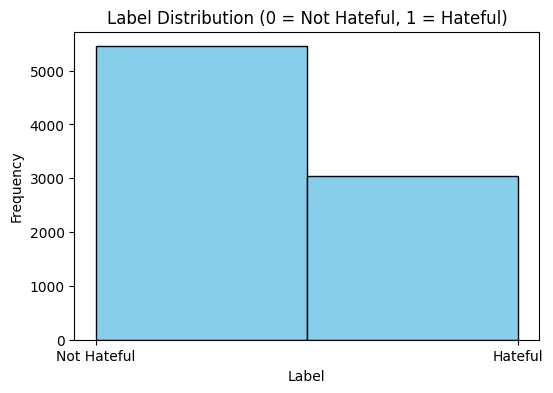

In [ ]:
import matplotlib.pyplot as plt

# Count the number of occurrences of each label
plt.figure(figsize=(6, 4))
plt.hist(labels, bins=2, edgecolor='black', color='skyblue')
plt.title("Label Distribution (0 = Not Hateful, 1 = Hateful)")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.xticks([0, 1], ['Not Hateful', 'Hateful'])
plt.show()

In [ ]:
# Check if image_ids match the filenames
image_ids = df_train['img'].values  # Assuming 'image_id' is the column name

# Check the first few image ids
print(image_ids[:5])

['img/42953.png' 'img/23058.png' 'img/13894.png' 'img/37408.png'
 'img/82403.png']


In [ ]:
import numpy as np
from PIL import Image

# Prepare an empty list for images and labels
X_train_images = []
y_train_labels = []

# Map image filenames to labels
for img_file, label in zip(df['img'][:5], df['label'][:5]):  # Use the 'img' and 'label' columns
    img_path = '/content/hateful-memes/data/' + img_file  # Correct path construction
    img = Image.open(img_path)

    # Resize the image to 224x224
    img_resized = img.resize((224, 224))

    # Convert image to numpy array
    img_array = np.array(img_resized)

    # Append to the image list and label list
    X_train_images.append(img_array)
    y_train_labels.append(label)

# Convert the list to numpy arrays
X_train_images = np.array(X_train_images)
y_train_labels = np.array(y_train_labels)

print(f"Shape of X_train_images: {X_train_images.shape}")
print(f"Shape of y_train_labels: {y_train_labels.shape}")

Shape of X_train_images: (5, 224, 224, 3)
Shape of y_train_labels: (5,)


In [ ]:
import numpy as np
from PIL import Image

# Prepare an empty list for images and labels
X_train_images = []
y_train_labels = []

# Map image filenames to labels
for img_file, label in zip(df['img'][:5], df['label'][:5]):  # Use the 'img' and 'label' columns
    img_path = '/content/hateful-memes/data/' + img_file  # Correct path construction
    img = Image.open(img_path)

    # Resize the image to 224x224
    img_resized = img.resize((224, 224))

    # Convert image to numpy array
    img_array = np.array(img_resized)

    # Append to the image list and label list
    X_train_images.append(img_array)
    y_train_labels.append(label)

# Convert the list to numpy arrays
X_train_images = np.array(X_train_images)  # Convert to numpy array
y_train_labels = np.array(y_train_labels)

# Normalize the images to the range [0, 1]
X_train_images = X_train_images / 255.0

# Check the shapes
print(f"Shape of X_train_images: {X_train_images.shape}")
print(f"Shape of y_train_labels: {y_train_labels.shape}")
import numpy as np
from PIL import Image

# Prepare an empty list for images and labels
X_train_images = []
y_train_labels = []

# Map image filenames to labels
for img_file, label in zip(df['img'][:5], df['label'][:5]):  # Use the 'img' and 'label' columns
    img_path = '/content/hateful-memes/data/' + img_file  # Correct path construction
    img = Image.open(img_path)

    # Resize the image to 224x224
    img_resized = img.resize((224, 224))

    # Convert image to numpy array
    img_array = np.array(img_resized)

    # Append to the image list and label list
    X_train_images.append(img_array)
    y_train_labels.append(label)

# Convert the list to numpy arrays
X_train_images = np.array(X_train_images)  # Convert to numpy array
y_train_labels = np.array(y_train_labels)

# Normalize the images to the range [0, 1]
X_train_images = X_train_images / 255.0

# Check the shapes
print(f"Shape of X_train_images: {X_train_images.shape}")
print(f"Shape of y_train_labels: {y_train_labels.shape}")

Shape of X_train_images: (5, 224, 224, 3)
Shape of y_train_labels: (5,)
Shape of X_train_images: (5, 224, 224, 3)
Shape of y_train_labels: (5,)


In [ ]:
# Normalize the images to the range [0, 1]
X_train_images = X_train_images / 255.0

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (80% train, 20% validation)
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train_images, y_train_labels, test_size=0.2, random_state=42)

# Check the shapes of the split datasets
print(f"Training data shape: {X_train_final.shape}, Labels shape: {y_train_final.shape}")
print(f"Validation data shape: {X_val_final.shape}, Labels shape: {y_val_final.shape}")

Training data shape: (4, 224, 224, 3), Labels shape: (4,)
Validation data shape: (1, 224, 224, 3), Labels shape: (1,)


In [ ]:
from transformers import TFBertModel, BertTokenizer
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Concatenate, Lambda
from tensorflow.keras.models import Model

# BERT tokenizer and model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Image input model
image_input = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)

# Text input model
text_input = Input(shape=(128,), dtype=tf.int32)  # Text input shape (batch_size, max_length)

# Preprocess text function
def preprocess_text(text_list):
    # Tokenizing a batch of text using the BERT tokenizer
    return bert_tokenizer(text_list, padding=True, truncation=True, max_length=128, return_tensors='tf')

# Function to extract BERT embeddings
def get_bert_embeddings(text_input):
    # Apply the BERT model to the tokenized text
    tokenized_text = preprocess_text(text_input)
    bert_output = bert_model(tokenized_text)  # BERT output
    text_embedding = bert_output.last_hidden_state  # Shape (batch_size, sequence_length, hidden_size)
    return tf.reduce_mean(text_embedding, axis=1)  # Average pooling over sequence length

# Get BERT embeddings for text input with Lambda layer
text_embedding = Lambda(get_bert_embeddings, output_shape=(768,))(text_input)  # Explicitly specify output shape

# Concatenate image and text features
z = Concatenate()([x, text_embedding])
z = Dense(64, activation='relu')(z)
z = Dropout(0.5)(z)
output = Dense(1, activation='sigmoid')(z)

# Build and compile the model
model = Model(inputs=[image_input, text_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 222, 222, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 111, 111, 32)   │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 394272)         │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 768)            │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 395040)         │              0 │ flatten[0][0],         │
│                           │                        │                │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │     25,282,624 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │             65 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 25,283,585 (96.45 MB)

 Trainable params: 25,283,585 (96.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Build a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification (hateful vs not hateful)
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()

# Train the model
history = model.fit(X_train_final, y_train_final, epochs=10, batch_size=32, validation_data=(X_val_final, y_val_final))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 1.0000 - loss: 0.6929 - val_accuracy: 1.0000 - val_loss: 0.6081
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 1.0000 - loss: 0.6078 - val_accuracy: 1.0000 - val_loss: 0.2990
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.3046 - val_accuracy: 1.0000 - val_loss: 0.0395
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0467 - val_accuracy: 1.0000 - val_loss: 7.4455e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 2.8275e-06
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 2.9899e-05 - val_accuracy: 1.0000 - val_loss: 2.9227e-09
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 6.6620e-09 - val_accuracy: 1.0000 - val_loss: 1.0458e-12
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 1.0092e-08 - val_accuracy: 1

In [ ]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_val_final, y_val_final)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 7.7739e-25
Validation Accuracy: 100.00%


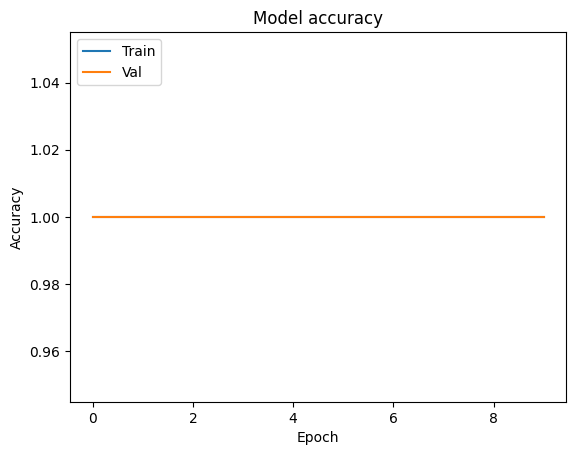

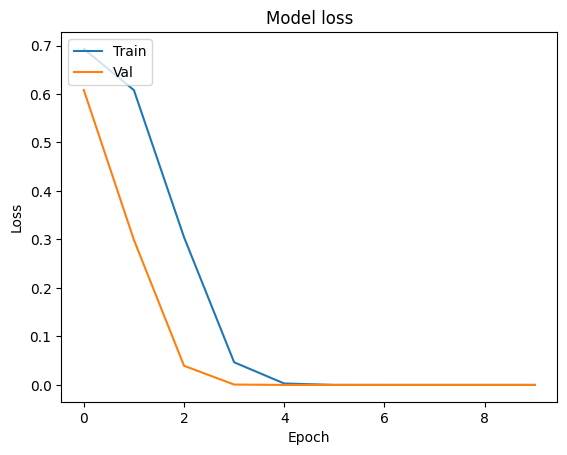

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
# Freeze BERT model layers
for layer in bert_model.layers:
    layer.trainable = False

In [ ]:
# Save the trained model
model.save('/content/hateful_meme_detection_model.keras')
print("Model saved successfully!")

Model saved successfully!


In [ ]:
class_weights = {0: 1, 1: 10}  # Adjust the weight as needed
model.fit(X_train_final, y_train_final, class_weight=class_weights)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 3.7335e-19


In [ ]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_val_final, y_val_final)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 3.4329e-29
Validation Loss: 3.432890982186596e-29
Validation Accuracy: 100.00%


In [ ]:
import numpy as np
from PIL import Image

# Prepare an empty list for images and labels
X_train_images = []
y_train_labels = []

# Map image filenames to labels
for img_file, label in zip(df['img'][:5], df['label'][:5]):  # Use the 'img' and 'label' columns
    # Correctly construct the image path
    img_path = '/content/hateful-memes/data/' + img_file

    # Print the constructed image path
    print(f"Loading image from: {img_path}")  # Print the constructed path

    # Open the image
    img = Image.open(img_path)

    # Resize the image to 224x224
    img_resized = img.resize((224, 224))

    # Convert image to numpy array
    img_array = np.array(img_resized)

    # Append to the image list and label list
    X_train_images.append(img_array)
    y_train_labels.append(label)

# Convert the list to numpy arrays
X_train_images = np.array(X_train_images)  # Convert to numpy array
y_train_labels = np.array(y_train_labels)

# Normalize the images to the range [0, 1]
X_train_images = X_train_images / 255.0

# Check the shapes
print(f"Shape of X_train_images: {X_train_images.shape}")
print(f"Shape of y_train_labels: {y_train_labels.shape}")


Loading image from: /content/hateful-memes/data/img/42953.png
Loading image from: /content/hateful-memes/data/img/23058.png
Loading image from: /content/hateful-memes/data/img/13894.png
Loading image from: /content/hateful-memes/data/img/37408.png
Loading image from: /content/hateful-memes/data/img/82403.png
Shape of X_train_images: (5, 224, 224, 3)
Shape of y_train_labels: (5,)


In [ ]:
# Check if file actually exists
import os
img_path = '/content/hateful-memes/data/img/82403.png'
if os.path.exists(img_path):
    print(f"File exists: {img_path}")
else:
    print(f"File not found: {img_path}")

File exists: /content/hateful-memes/data/img/82403.png


In [ ]:
# Remove the 'img/' prefix from the image filenames if present
df_test['img'] = df_test['img'].str.replace('img/', '', regex=False)

# Check the first few filenames to confirm the change
print(df_test['img'].head())

0    16395.png
1    37405.png
2    94180.png
3    54321.png
4    97015.png
Name: img, dtype: object


In [ ]:
print(df_test.columns)

Index(['id', 'img', 'text'], dtype='object')


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
# Example: Try predicting on a known example from the training set
example_image_data = X_train_images[0:1]  # First example in training set
example_text_data = X_train_final[0:1]  # First text example
prediction = model.predict([example_image_data, example_text_data])
print(f"Prediction on known data: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
Prediction on known data: [[0.]]


In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
from transformers import BertTokenizer
import tensorflow as tf

# Upload the image
uploaded = files.upload()

# Get the uploaded image path
new_image_path = list(uploaded.keys())[0]  # Get the file name of the uploaded image
print(f"Image uploaded: {new_image_path}")

# BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Function to load and preprocess new image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)  # Convert to NumPy array
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array

# Function to tokenize new text
def tokenize_text(text_list, tokenizer):
    return tokenizer(text_list, padding=True, truncation=True, max_length=128, return_tensors='tf')

# New image and text data (replace with actual text)
new_text = "This is a new meme."

# Preprocess the new image
new_image_data = load_and_preprocess_image(new_image_path)
new_image_data = np.expand_dims(new_image_data, axis=0)  # Add batch dimension

# Tokenize the new text
new_text_data = tokenize_text([new_text], bert_tokenizer)

# Predict using the model
predictions = model.predict([new_image_data, new_text_data['input_ids']])
print(f"Raw prediction output: {predictions}")

print(new_text_data)
print(new_text_data['input_ids'])  # Check tokenized text


prediction_threshold = 0.3  # Adjust as needed
predicted_class = 'Hateful' if predictions[0] < prediction_threshold else 'Not Hateful'
print(f"Predicted class: {predicted_class}")



Saving WhatsApp Image 2024-12-11 at 10.50.04 PM.jpeg to WhatsApp Image 2024-12-11 at 10.50.04 PM.jpeg
Image uploaded: WhatsApp Image 2024-12-11 at 10.50.04 PM.jpeg


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Raw prediction output: [[0.]]
{'input_ids': <tf.Tensor: shape=(1, 9), dtype=int32, numpy=
array([[ 101, 2023, 2003, 1037, 2047, 2033, 4168, 1012,  102]],
      dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 9), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 9), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}
tf.Tensor([[ 101 2023 2003 1037 2047 2033 4168 1012  102]], shape=(1, 9), dtype=int32)
Predicted class: Hateful


In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
from transformers import BertTokenizer
import tensorflow as tf

# Upload the image
uploaded = files.upload()

# Get the uploaded image path
new_image_path = list(uploaded.keys())[0]  # Get the file name of the uploaded image
print(f"Image uploaded: {new_image_path}")

# BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Function to load and preprocess new image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)  # Convert to NumPy array
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array

# Function to tokenize new text
def tokenize_text(text_list, tokenizer):
    return tokenizer(text_list, padding=True, truncation=True, max_length=128, return_tensors='tf')

# New image and text data (replace with actual text)
new_text = "This is a new meme."

# Preprocess the new image
new_image_data = load_and_preprocess_image(new_image_path)
new_image_data = np.expand_dims(new_image_data, axis=0)  # Add batch dimension

# Tokenize the new text
new_text_data = tokenize_text([new_text], bert_tokenizer)

# Predict using the model
predictions = model.predict([new_image_data, new_text_data['input_ids']])
print(f"Raw prediction output: {predictions}")

print(new_text_data)
print(new_text_data['input_ids'])  # Check tokenized text


prediction_threshold = 0.3  # Adjust as needed
predicted_class = 'Hateful' if predictions[0] > prediction_threshold else 'Not Hateful'
print(f"Predicted class: {predicted_class}")



Saving WhatsApp Image 2024-12-11 at 10.50.05 PM.jpeg to WhatsApp Image 2024-12-11 at 10.50.05 PM.jpeg
Image uploaded: WhatsApp Image 2024-12-11 at 10.50.05 PM.jpeg


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Raw prediction output: [[0.]]
{'input_ids': <tf.Tensor: shape=(1, 9), dtype=int32, numpy=
array([[ 101, 2023, 2003, 1037, 2047, 2033, 4168, 1012,  102]],
      dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 9), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 9), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}
tf.Tensor([[ 101 2023 2003 1037 2047 2033 4168 1012  102]], shape=(1, 9), dtype=int32)
Predicted class: Not Hateful
